## SAIL SQUIRE Terrain Contour Plot

In [1]:
## github repo: https://github.com/ARM-Development/sail-xprecip-radar.git

In [2]:
import os
import glob
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import fiona
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from math import atan2 as atan2
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import pyart
import act

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
from xmovie import Movie

/opt/homebrew/Caskroom/miniforge/base/envs/graphs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%matplotlib inline

In [5]:
fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default

In [6]:
def _generate_title(radar, ds, field, sweep):
    """ Generates a title for each plot. """
    time_str = ds['time'].data[0]
    fixed_angle = radar.fixed_angle['data'][sweep]
    line_one = "%.1f Deg. %s " % (fixed_angle, time_str)
    field_name = str(field)
    field_name = field_name.replace('_', ' ')
    field_name = field_name[0].upper() + field_name[1:]
    return line_one + '\n' + field_name

def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 3.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

In [7]:
def plot_eastriver(axs, ncolor, scale_color='black', zoom=False):
    min_lat = 38.5
    max_lat = 39.3
    min_lon = -107.45
    max_lon = -106.45
    # zoomed in
    zoom_min_lat = 38.85
    zoom_max_lat = 39.05
    zoom_min_lon = -107.1
    zoom_max_lon = -106.80
    
    # Plot the East River Watershed domain
    east_river.plot(ax=axs, linewidth=2, edgecolor=ncolor, facecolor='None', linestyle=':',)

    axs.plot(0,
             0,
             color=ncolor,
             linestyle=':',
             label='East River Watershed')

    plt.legend(loc='upper right',
               fontsize=12)

    if zoom is True:
        plt.xlim(zoom_min_lon, zoom_max_lon)
        plt.ylim(zoom_min_lat, zoom_max_lat)
    else:
        plt.xlim(min_lon, max_lon)
        plt.ylim(min_lat, max_lat)

    # Add our scale bar
    add_scale_line(10.0, axs, projection=ccrs.PlateCarree(), 
                   color=scale_color, linewidth=3,
                   fontsize=14,
                   fontweight='bold')

    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(),
                       draw_labels=True,
                       linewidth=1, 
                       color='gray', 
                       alpha=0.3,
                       linestyle='--')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())

    # Make sure labels are only plotted on the left and bottom
    gl.top_labels = False
    gl.right_labels = False

    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}


In [8]:
def squire_grid(ds, fig, tt, *args, **kwargs):
    
    # Set up the figure
    myf = fig
    
    # We are going FULL CUSTOM.. This sets up the map panel
    map_panel_axes = [0.05, 0.05, .8, .8]

    # Add the map axes. Wse the Platte Carree projection. 
    axarr = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())
    
    # Select the time for input frame; subset snowfall rate DataArray
    da = ds['snow_rate_m2009_1'].isel(time=tt).load()

    # Use inherent xarray plotting, pass subplot argument
    da.plot(x='lon', 
            y='lat', 
            cmap='Blues',
            vmin=0,
            vmax=15,
            ax=axarr)
    
    # Call our East River domain plot
    plot_eastriver(axarr, ncolor='black', zoom=True)

    # XMovie throws errors if this isn't included
    return None, None

In [9]:
# Grab all locally stored SQUIRE files
# SQUIRE Data can be found here: https://adc.arm.gov/discovery/#/results/datastream::gucxprecipradarsquireM1.c1
file_list = sorted(glob.glob("/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314*"))
file_list[:10]

['/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.000239.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.000759.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.001319.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.002359.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.003439.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.004519.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.005039.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.010119.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.011159.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/squire/gucxprecipradarsquireM1.c1.20220314.011719.nc']

In [10]:
# KML File within: /sail-xprecip-radar/data/site-locations/ directory on the repo
east_river = gpd.read_file('~/dev/sail-xprecip-radar/data/site-locations/East_River.kml')

## Single SQUIRE File

In [11]:
# Read a file
ds = xr.open_dataset(file_list[100])

In [12]:
ds

<xarray.Dataset>
Dimensions:                 (time: 1, y: 161, x: 161)
Coordinates:
  * time                    (time) datetime64[ns] 2022-03-14T11:25:22
    lat                     (y) float64 ...
  * y                       (y) float64 -2e+04 -1.975e+04 ... 1.975e+04 2e+04
    lon                     (x) float64 ...
  * x                       (x) float64 -2e+04 -1.975e+04 ... 1.975e+04 2e+04
    z                       (time, y, x) float64 ...
Data variables:
    DBZ                     (time, y, x) float64 ...
    corrected_reflectivity  (time, y, x) float64 ...
    rain_rate_A             (time, y, x) float64 ...
    snow_rate_ws88diw       (time, y, x) float64 ...
    snow_rate_m2009_1       (time, y, x) float64 ...
    snow_rate_m2009_2       (time, y, x) float64 ...
    snow_rate_ws2012        (time, y, x) float64 ...
    lowest_height           (time, y, x) float64 ...
Attributes: (12/23)
    command_line:          
    Conventions:           ARM-1.3 CF/Radial instrument_parameters
    process_version:       
    dod_version:           
    site_id:               
    platform_id:           
    ...                    ...
    translator:            https://www.arm.gov/capabilities/instruments/xprec...
    mentors:               https://www.arm.gov/connect-with-arm/organization/...
    source:                Colorado State University's X-Band Precipitation R...
    input_datastreams:     xprecipradarcmacppi.c1
    fields:                DBZ, corrected_reflectivity, time, lowest_height, ...
    history:

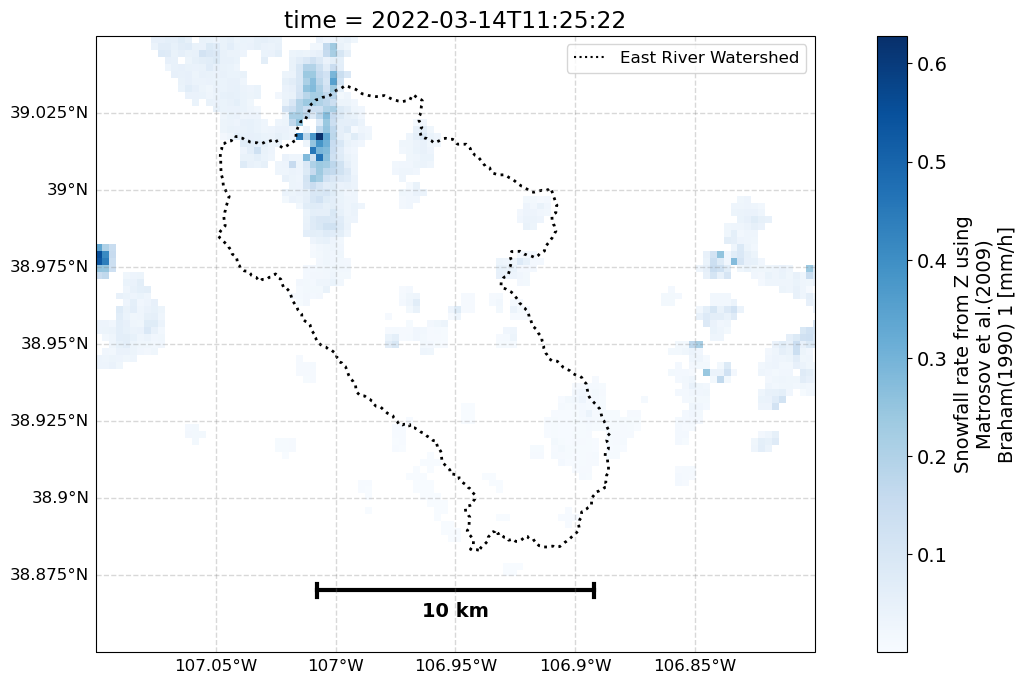

In [13]:
fig = plt.figure(figsize=(16, 8))

axarr = plt.subplot(111, projection=ccrs.PlateCarree())

# Use inherent xarray plotting, pass subplot argument
ds.snow_rate_m2009_1.plot(x='lon', 
                          y='lat', 
                          cmap='Blues',
                          ax=axarr)
plot_eastriver(axarr, ncolor='black', zoom=True)


#axarr.set_ylabel('')
#axarr.set_xlabel('')
#axarr.grid(True)

## With XMovie

In [14]:
# Read in all the SQUIRE files into a single Xarray Dataset
squire = xr.open_mfdataset(file_list)

(None, None)

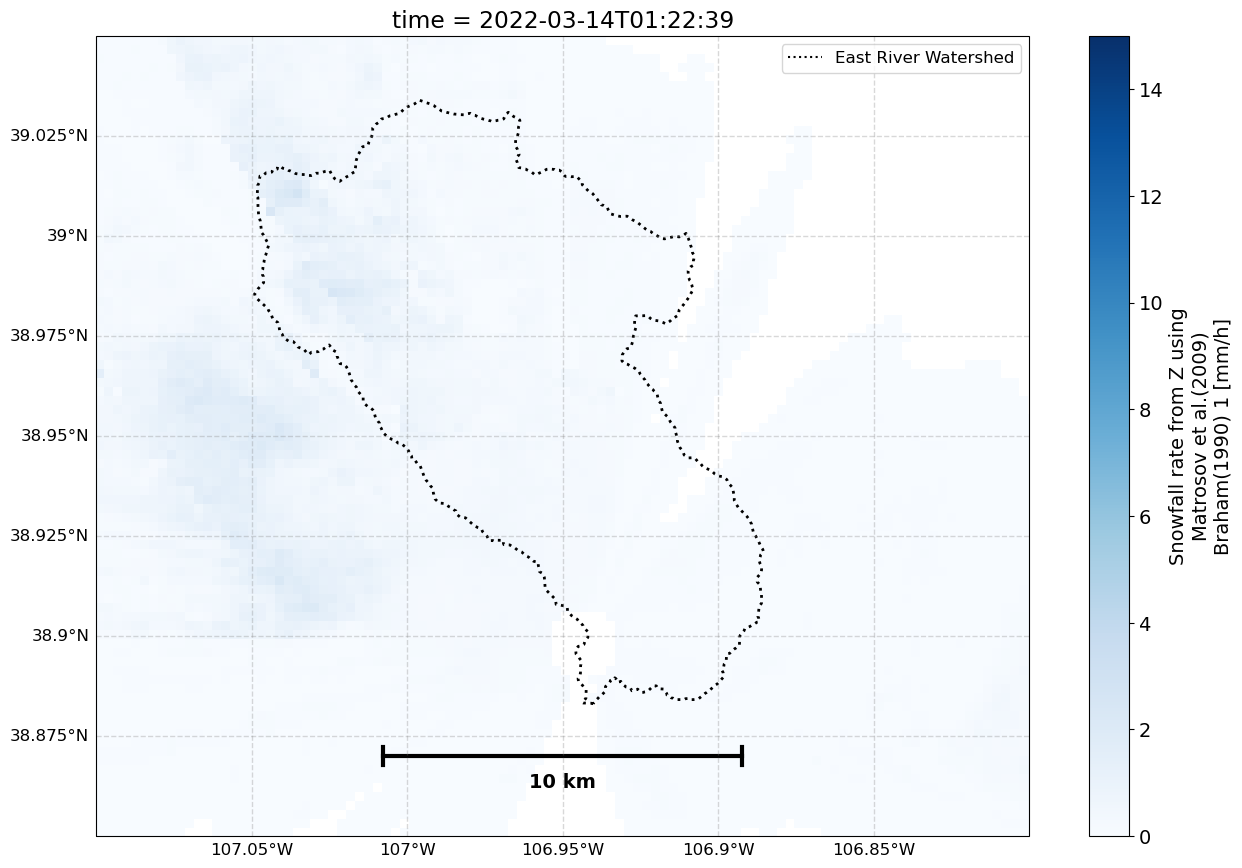

In [15]:
# Let's test out that the SQUIRE_GRID plotting function works
figme = plt.figure(figsize=[15,10])
squire_grid(squire, figme, 10)

In [16]:
# Build the movie with 'XMovie'
mov_parallel = Movie(squire,
                     squire_grid, input_check=False, 
                     dpi=150, framedim='time')#, dpi=300, pixelwidth=4800, pixelheight=1980,)

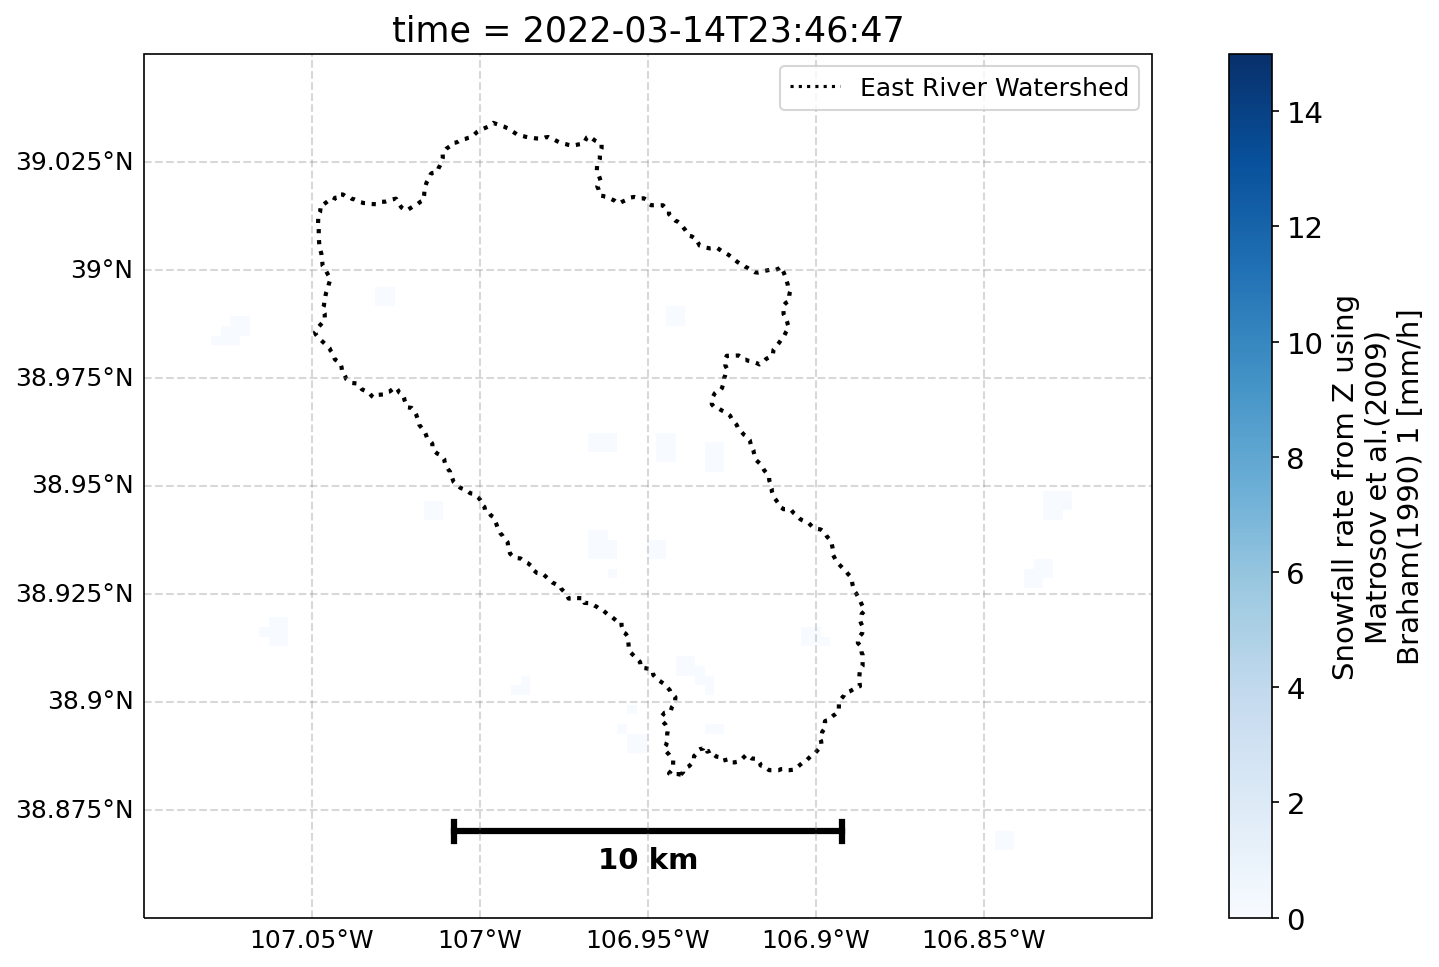

In [17]:
# Will need the matplotlib inline set to see this figure.
# Grab the last frame of the movie to check how it went. 
mov_parallel.preview(-1)

## Save the movie

In [18]:
mov_parallel.save(
    'squire.mov',
    overwrite_existing=True,
    gif_resolution_factor=2.0,framerate=5
)

Movie created at squire.mov


In [19]:
# Convert the movie to a gif
!ffmpeg -y -i squire.mov -f gif squire2.gif

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566267822/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566267822/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-gpl --enable-libx264 --enable

### Note: Following GIF is run in a markdown cell

![SegmentLocal](squire2.gif "segment")

In [21]:
# use magic -  ![SegmentLocal](yourgifname.gif "segment")